In [1]:
#imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
import random
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [56]:
num_samples = 50
num_centers = 3
num_features = 2

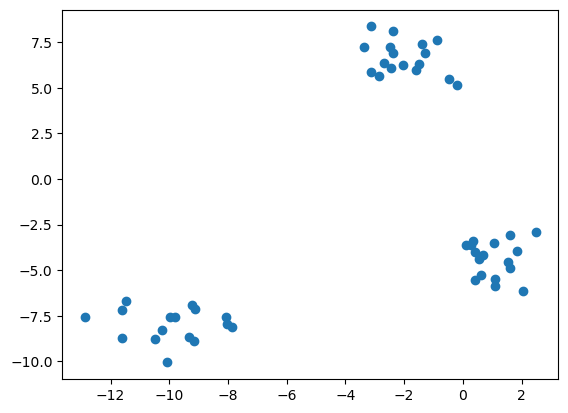

In [57]:
X,y = make_blobs(n_samples=num_samples,centers=num_centers,n_features=num_features,random_state = 100)
#visualize this data set
plt.scatter(X[:,0], X[:,1])
plt.show()

In [58]:
class GMM:
    
    import numpy as np 
    import random
    from scipy.stats import multivariate_normal
    from matplotlib.patches import Ellipse
    
    def __init__(self, X , num_clusters , tolerance = 1e-5 , max_iter=1000):
        self.data = X 
        self.num_clusters = num_clusters
        self.tolerance = tolerance
        self.num_points = self.data.shape[0]
        self.num_features= self.data.shape[1]
        self.max_iter= max_iter 
        
    def __repr__(self):
        return f"GMM(Number of data points = {self.num_points} , Number of clusters = {self.num_clusters})"
    
    def kmeans_init(self):
        centroids = self.data[np.random.choice(self.num_points , self.num_clusters , replace=False)]
            
        def euclid_distance(point1 , point2):
            if(point1.shape != point2.shape):
                raise ValueError("The shapes of the vectors are not same!")
            else:
                return np.linalg.norm(point1-point2)

        def make_clusters(data , centroids): 
            cluster = []
            for point in data :
                distance = []
                for i in centroids:
                    distance.append(euclid_distance(i , point))
                cluster.append(np.argmin(distance))
            return np.array(cluster)
        
        def update_centroids(data , cluster , k):
            new_centroids = []
            for i in range(k):
                cluster_points = data[cluster == i]
                if len(cluster_points) > 0 : 
                    new_centroids.append(np.mean(cluster_points , axis = 0))
                else : 
                    new_centroids.append(data[np.random.choice(data.shape[0] , k , replace=False)])
            return np.array(new_centroids)

        for k in range(self.max_iter):
            cluster = make_clusters(self.data, centroids)
            new_centroids = update_centroids(self.data , cluster , self.num_clusters)
            
            if(np.all(np.abs(centroids - new_centroids)) < self.tolerance):
                break 
            centroids = new_centroids
            
        return centroids
    
    def get_params(self):
        self.means = self.kmeans_init()
        self.covariances = self.init_covariance()
        self.Pis = np.ones(self.num_clusters)/self.num_clusters 
        self.lamdas = np.zeros((self.num_points , self.num_clusters))
        
    def init_covariance(self):
        '''
            Initialises a diagonal matrix using identity matrix added with a regularisation term to 
            maintain positive semi definiteness 
        '''
        cov = []
        regularisation = self.tolerance 
        for k in range(self.num_clusters):
            cov.append(np.eye(self.num_features))
        
        cov = np.array(cov)
        cov.flat[:: num_features + 1] += regularisation # Add regularization to the diagonal
        return cov
    
    def get_full_covariances(self):
        for j in range(self.num_clusters):
            diff = self.data - self.means[j]
            weighted_diff = self.lamdas[: , j].reshape(-1, 1) * (diff)
            
            self.covariances[j] = np.dot(weighted_diff.T , diff)/np.sum(self.lamdas[: , j])
            self.covariances[j].flat[::self.num_features + 1] += self.tolerance
        return 
    
    def update_pis(self):
        for j in range(self.num_clusters):
            self.Pis[j] = np.sum(self.lamdas[:, j]) / self.num_points
        return 
    
    def update_means(self):
        for j in range(self.num_clusters):
            weighted_sum = np.sum(self.lamdas[: , j].reshape(-1 , 1) * self.data , axis = 0)
            self.means[j] = weighted_sum / np.sum(self.lamdas[: , j] , axis = 0)
        return 
    
    def fit(self):
        self.get_params()
        
        old_means = self.means 
        converge = False 
        while not converge:
            #expectation step 
            for j in range(self.num_clusters):
                covariance = self.covariances[j]
                self.lamdas[: , j] = multivariate_normal.pdf(self.data, mean=self.means[j], cov=covariance)
                self.lamdas[: , j] *= self.Pis[j]
            self.lamdas /= np.sum(self.lamdas , axis=1 , keepdims=True) + 1e-8 #prevent div by 0
            
            #maximisation step 
            self.update_means()
            self.get_full_covariances()
            self.update_pis()
            
            if(np.allclose(self.means, old_means, atol=self.tolerance)):
                converge = True 
            else : 
                old_means = np.copy(self.means)
        
        return (self.means, self.covariances , self.lamdas)
        
# Toy example       
g = GMM(X,num_centers)
means , covariances , lamdas = g.fit()

print("\n Means : " , means)
print("\n covariances : " , covariances)

# print("\n Lamdas : " , lamdas)


 Means :  [[ 1.04675609 -4.37153434]
 [-9.93501309 -7.96820406]
 [-1.93938156  6.49880071]]

 covariances :  [[[ 0.46716396 -0.01194497]
  [-0.01194497  0.954501  ]]

 [[ 1.91216571 -0.10303323]
  [-0.10303323  0.73888218]]

 [[ 0.83528827 -0.15910495]
  [-0.15910495  0.63974729]]]


In [59]:
def plot_gmm_results(X, means, covariances, lamda, n_components=3):
    """
    Visualize GMM clustering results for multidimensional data with covariance matrices.

    Parameters:
        X: np.ndarray
            Input data (num_points, num_features).
        means: np.ndarray
            Cluster means (k, num_features).
        covariances: np.ndarray
            Cluster covariance matrices (k, num_features, num_features).
        lamda: np.ndarray
            Responsibility matrix (num_points, k).
        n_components: int
            Number of components for dimensionality reduction (default is 3 for 3D).
    """
    num_points, num_features = X.shape
    k = means.shape[0]
    
    # Assign clusters based on the maximum responsibility
    cluster_assignments = np.argmax(lamda, axis=1)

    X_reduced = X
    means_reduced = means
    covariances_reduced = covariances

    # Plotting
    if num_features == 2:
        
        plt.figure(figsize=(10, 8))
        for cluster in range(k):
            points_in_cluster = X_reduced[cluster_assignments == cluster]
            plt.scatter(
                points_in_cluster[:, 0], 
                points_in_cluster[:, 1], 
                label=f"Cluster {cluster+1}", 
                alpha=0.6
            )

            # Plot cluster means
            plt.scatter(
                means_reduced[cluster, 0], 
                means_reduced[cluster, 1], 
                color='red', 
                marker='x', 
                s=200, 
                label=f"Mean {cluster+1}"
            )

            # Plot covariance ellipses (using full covariance matrix)
            draw_covariance_ellipse(means_reduced[cluster], covariances[cluster], ax=plt.gca())
        
        plt.title("GMM Clustering Results (2D)")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.grid(True)
        plt.show()


def draw_covariance_ellipse(mean, cov_matrix, ax=None, n_std=1.0, **kwargs):
    """
    Draw a 2D ellipse representing the covariance matrix.
    """
    if ax is None:
        ax = plt.gca()

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues)

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ellipse.set_alpha(0.4)
    ax.add_patch(ellipse)


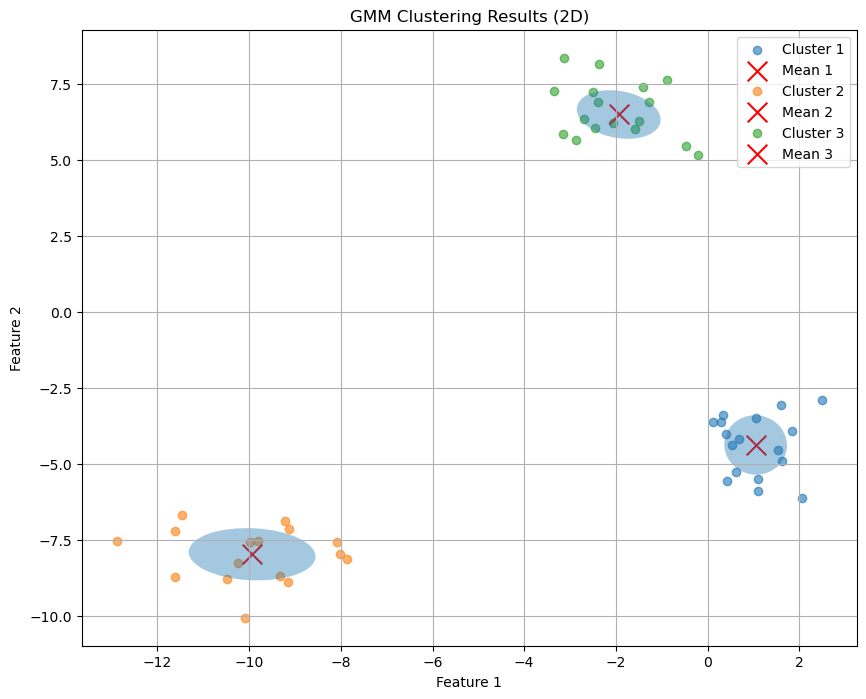

In [60]:
 plot_gmm_results(X, means, covariances, lamdas)

## Comparing with Sklearn's GMM

In [61]:
from sklearn.mixture import GaussianMixture

In [62]:
gm = GaussianMixture(n_components=3).fit(X)

In [63]:
gm.means_

array([[-9.93501582, -7.96820371],
       [-2.01743726,  6.64431887],
       [ 1.04675679, -4.37153301]])

In [64]:
"""
     Means from our model 
     
 [[ 1.04675609 -4.37153434]
 [-9.93501309 -7.96820406]
 [-1.93938156  6.49880071]]

""" 


'\n     Means from our model \n     \n[[-9.89094646 -7.67183172]\n [ 0.95797878 -4.47942876]\n [-1.56293904  6.88879235]]\n\n'